<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 5 – Estacionaridade: Rolling Statistics, Autocorrelação e Teste Dickey-Fuller</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br

### Estacionaridade

- Uma série temporal é considerada estacionária se suas propriedades estatísticas, como média e variância, permanecerem constantes ao longo do tempo.

- A maioria dos modelos de séries temporais trabalha com o pressuposto de que a série temporal é estacionária. A principal razão para isso é que existem muitas maneiras pelas quais uma série pode ser não estacionária, mas apenas uma para estacionariedade.

- Intuitivamente, podemos dizer que, se uma série temporal tem um comportamento específico ao longo do tempo, há uma probabilidade muito alta de que ela siga o mesmo no futuro.

- Além disso, as teorias relacionadas às séries estacionárias são mais maduras e mais fáceis de implementar em comparação às séries não estacionárias.

A estacionariedade é um importante conceito na modelagem de séries temporais e é caracterizada por uma variável que se comporta de forma aleatória ao longo do tempo ao redor de uma média constante.

Basicamente, séries temporais que possuem tendência e/ou sazonalidade não são estacionárias e é necessário o uso de técnicas adequadas a tal situação. 

### Carregando e Preparando os Dados

Vamos carregar os dados e prepará-los para mais uma rodada de análise.

In [0]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [0]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [0]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [0]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

seaborn         0.10.0
statsmodels.api 0.10.2
pandas          0.25.3
matplotlib      3.2.0
Data Science Academy


Vamos carregar um dataset com uma série temporal.

O dataset é público e pode ser encontrado aqui:

https://www.kaggle.com/rakannimer/air-passengers

O conjunto de dados AirPassenger fornece totais mensais de passageiros de uma companhia aérea dos EUA, de 1949 a 1960. Esse conjunto de dados já é de uma classe de série temporal, portanto, nenhuma manipulação adicional de classe ou data é necessária.

In [0]:
# Carrega os dados
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset1.csv', header = None)

In [0]:
# Ajustando o nome de cada coluna
dados.columns = ['mes','passageiros']

Vamos converter a data do tipo object (string) para o tipo apropriado, datetime, pois assim podemos usar métodos e atributos específicos de datas.

In [0]:
# Convertendo a coluna data de object para datetime  
dados['mes'] = pd.to_datetime(dados['mes'], format = '%Y-%m')

In [0]:
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
dados_serie = dados.set_index('mes')

Agora sim podemos chamar esse conjunto de dados de série temporal. Vamos visualizar o índice:

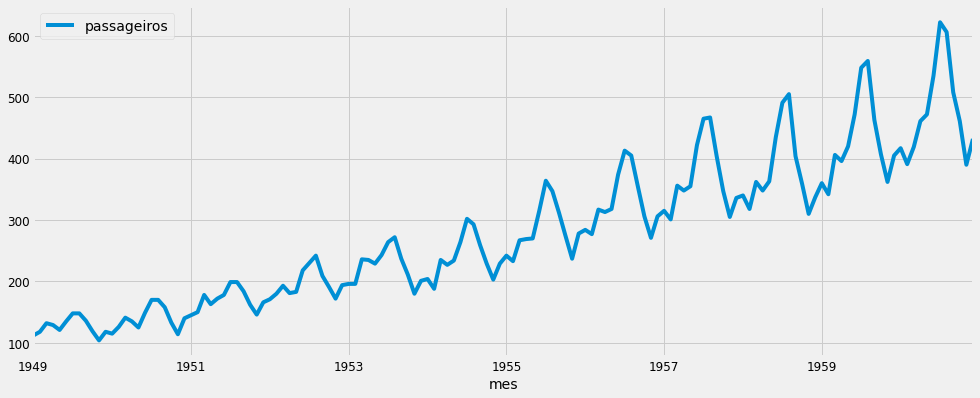

In [0]:
# Plot da série temporal
dados_serie.plot(figsize = (15, 6))
plt.show()

O gráfico acima mostra 2 componentes da série: Sazonalidade e Tendência.

- Sazonalidade - o fenômeno se repete em períodos fixos.

- Tendência - ao longo do tempo, a série segue uma tendência de crescimento.

### Verificando a Estacionariedade

Podemos verificar a estacionariedade de uma série temporal da seguinte forma:

- **Plot das Rolling Statistics (Estatísticas Móveis)**: Podemos criar um plot da média móvel e variância móvel (ou desvio padrão, que é a raiz quadrada da variância) e ver se variam com o tempo. A média / variância móvel é, para qualquer instante 't', a média / variância do último ano, ou seja, os últimos 12 meses. Curiosidade: mostramos como aplicar Rolling Statistics a dados em tempo real usando o Apache Spark no curso Machine Learning e IA em Ambientes Distribuídos da Formação Engenheiro de Dados.


- **Autocorrelação com Gráficos ACF e PACF**: Se a série temporal for estacionária, os gráficos ACF / PACF (gráficos de autocorrelação da série) mostrarão um padrão específico o qual discutiremos mais adiante. Curiosidade: mostramos como calcular a correlação em R no curso Análise Estatística Para Data Science II da Formação Análise Estatística.


- **Teste Dickey-Fuller**: Este é um dos testes estatísticos para verificar a estacionariedade. Aqui, a hipótese nula é que a série temporal não é estacionária. Os resultados do teste incluem uma estatística de teste e alguns valores críticos para os níveis de confiança das diferenças. Se a 'Estatística de teste' for menor que o 'valor crítico', podemos rejeitar a hipótese nula e dizer que a série é estacionária. Curiosidade: mostramos como realizar o Teste Dickey-Fuller em R no curso Análise Estatística Para Data Science II da Formação Análise Estatística.

Usaremos os 3 métodos para checar se a nossa série é estacionária ou não.

### O Que São Lags (Defasagens ou Atrasos)?

Uma maneira de analisar os dados de séries temporais é plotar cada observação contra outra observação que 
ocorreu algum tempo antes. Por exemplo, você pode plotar yt contra yt-1. Nesse caso, yt-1 é o atraso da série, o lag.

As correlações associadas aos gráficos de atraso formam o que é chamado de "função de autocorrelação".  A autocorrelação é quase a mesma que a correlação de Pearson (que usamos em modelos de Regressão). No entanto, a autocorrelação é a correlação de uma série temporal com uma cópia atrasada (lag, atraso ou defasagem) de si mesma.

A função de autocorrelação (ACF) é o principal método na análise de séries temporais para quantificar o nível 
de correlação entre uma série e seus atrasos. Esse método é bastante semelhante (matematicamente e logicamente) 
ao coeficiente de correlação de Pearson.

### Autocorrelação

Os modelos estatísticos mais conhecidos e utilizados, como a Regressão Linear e o Regressão Logística, são adequados na modelagem de variáveis em que as observações são independentes. Em uma série temporal, não há como desconsiderar a estrutura de dependência das observações.

Por exemplo, a quantidade vendida  de sorvete em janeiro pode estar relacionada à quantidade vendida em dezembro, que por sua vez pode estar relacionada com a de novembro e assim por diante. Dessa forma, a utilização desses modelos pode gerar resultados enviesados e que não refletem a realidade.

A autocorrelação é definida como uma observação num determinado instante está relacionada às observações passadas.

As observações podem estar autocorrelacionadas em diversas ordens. A autocorrelação de primeira ordem caracteriza séries onde uma observação está correlacionada com a observação imediatamente anterior (janeiro e dezembro, por exemplo). A autocorrelação de segunda ordem caracteriza séries temporais onde uma observação está correlacionada com as observações a 2 unidades de tempo no passado (janeiro e novembro, por exemplo).

A identificação da autocorrelação é feita através da Função de Autocorrelação (ACF – Autocorrelation Function), mostrada abaixo. Além disso, testes como o de Durbin Watson auxiliam na identificação da autocorrelação de primeira ordem.

A autocorrelação é uma ferramenta matemática para encontrar padrões de repetição, como a presença de um sinal periódico obscurecidos pelo ruído. Um diagrama de autocorrelações apresenta os valores de autocorrelação de uma amostra versus o intervalo de tempo em que foi calculado. Autocorrelações devem ser próximas de zero para aleatoriedade. A ocorrência de não estacionariedade é denotada pela lenta queda da ACF nos primeiros lags da série. Isto significa que a série deve ser diferenciada, e que um modelo ARIMA ou SARIMA deve ser aplicado.

Antes de iniciar qualquer modelagem preditiva é necessário verificar se essas propriedades estatísticas são constantes na série temporal:

- Média constante
- Variância constante
- Autocorrelacionada

Vamos ao trabalho!

### Plot das Rolling Statistics (Estatísticas Móveis)

Primeiro, vamos checar se as estatísticas móveis são ou não constantes ao longo da série temporal.

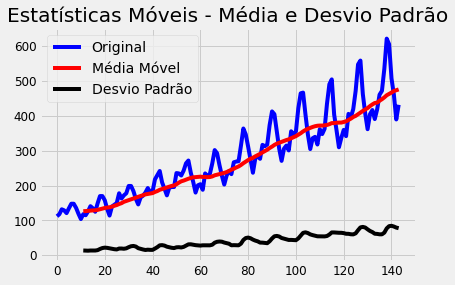

In [0]:
# Prepara os dados
x = dados['mes'].values
y = dados['passageiros'].values

# Determinando estatísticas móveis
rolmean = dados.rolling(window = 12).mean()
rolstd = dados.rolling(window = 12).std()

# Plot das estatísticas móveis
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
plt.legend(loc = 'best')
plt.title('Estatísticas Móveis - Média e Desvio Padrão')
plt.show()

Análise:
    
- Observamos que a média móvel e o desvio padrão não são constantes em relação ao tempo (tendência crescente).
- A série cronológica não é, portanto, estacionária.

### Plots ACF e PACF

Vamos criar os gráficos da função de autocorrelação (ACF) e da função de autocorrelação parcial (PACF).

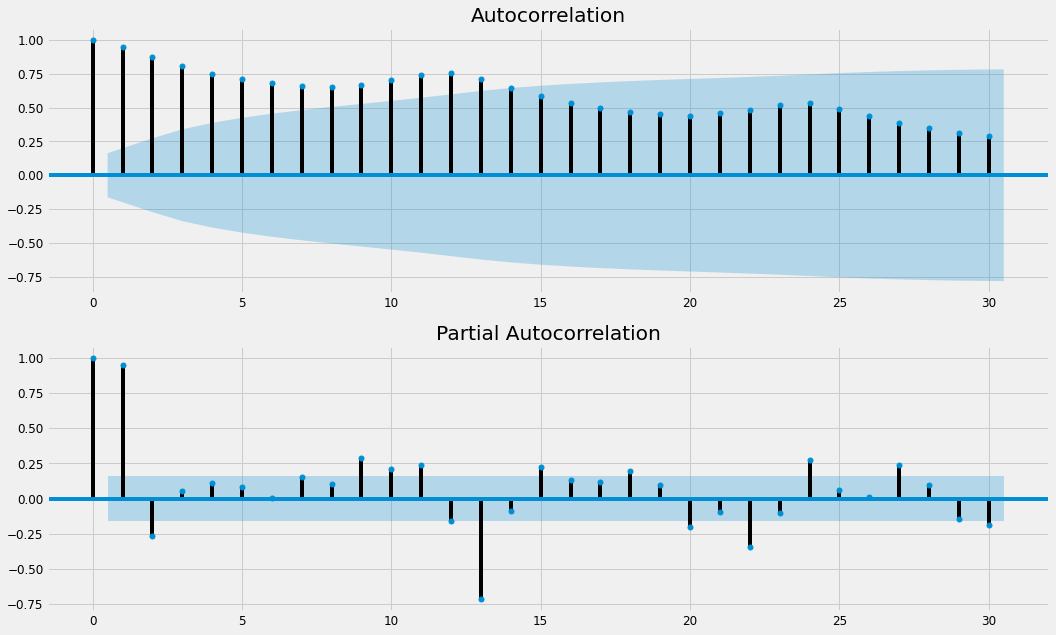

In [0]:
# Plots
plt.rcParams.update({'figure.figsize': (16,10)})

# Plot do gráfico ACF
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
plt.subplot(211)
plot_acf(dados_serie.passageiros, ax = plt.gca(), lags = 30)

# Plot do gráfico PACF
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html
plt.subplot(212)
plot_pacf(dados_serie.passageiros, ax = plt.gca(), lags = 30)
plt.show()

Interpretação dos Gráficos:
    
No gráfico, o eixo vertical indica a autocorrelação e o horizontal a defasagem. 

A área sombreada em azul indica onde é significativamente diferente de zero. Como é possível ver na imagem, temos diversos valores ACF (barras verticais) acima do limite da área sombreada em azul. Nesses casos, a autocorrelação é diferente de zero, indicando que a série não é aleatória – conforme o esperado.

Algumas barras verticais estão dentro do limite da área sombreada em azul, Ou seja, a autocorrelação entre a série com alguns de seus lags é igual a zero, indicando que não há correlação.

Em termos simples: a área sombreada em azul aponta a significância. Se ultrapassa é porque tem correlação.

Cada barra no gráfico ACF representa o nível de correlação entre a série e seus atrasos em  ordem cronológica. A área sombreada em azul indica se o nível de correlação entre a série e cada atraso é significativo ou não. 

Testando a hipótese nula de que a correlação do atraso com a série é igual a zero, podemos rejeitá-la sempre que o nível de correlação estiver acima ou abaixo da área sombreada em azul com um nível de significância de 5%. 

Caso contrário, sempre que a correlação estiver dentro da área sombreada em azul,  deixamos de rejeitar a hipótese nula e, portanto, podemos ignorar esses atrasos (ou assumir que não há correlação significativa entre eles e a série). 

O PACF é apenas uma visualização parcial do ACF.

Análise:
    
- Se a série temporal for estacionária, os gráficos do ACF / PACF mostrarão uma "queda rápida na correlação" após um pequeno atraso entre os pontos. Não é o caso em nossos gráficos. A queda lenda (redução do tamanho das barras) indica que essa série não é estacionária).


- Os dados da nossa série não são estacionários, pois um número alto de observações anteriores está correlacionado com valores futuros.


- Intervalos de confiança são desenhados na área azul clara. Por padrão, isso é definido como um intervalo de confiança de 95%, sugerindo que os valores de correlação fora desta área provavelmente são uma correlação e não um acaso estatístico.


- Teremos que transformar essa série em estacionária antes de criar um modelo preditivo. Veremos como fazer isso na próxima aula.

### Teste Dickey-Fuller aumentado

- A intuição por trás do teste é que, se a série for integrada, o nível de atraso da série y (t-1) não fornecerá informações relevantes na previsão da mudança em y (t).


- Hipótese nula: a série temporal não é estacionária.


- Rejeitar a hipótese nula (ou seja, um valor-p abaixo de 0.05) indicará estacionaridade.

In [0]:
# Teste Dickey-Fuller

# Print
print('\nResultado do Teste Dickey-Fuller:\n')

# Teste
dfteste = adfuller(dados_serie.passageiros, autolag = 'AIC')

# Formatando a saída
dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                           'Valor-p',
                                           'Número de Lags Consideradas',
                                           'Número de Observações Usadas'])

# Loop por cada item da saída do teste
for key,value in dfteste[4].items():
    dfsaida['Valor Crítico (%s)'%key] = value

# Print
print (dfsaida)


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.815369
Valor-p                           0.991880
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64


Análise:

- O Valor-p é maior que 0.05. Não temos evidências para rejeitar a hipótese nula de que a série não é estacionária.

E aqui um presente para você. Uma função que executa o teste de estacionaridade e pode ser aplicada a qualquer série para testar se ela é ou não estacionária.

Se a série não for estacionária, teremos que aplicar transformações antes da modelagem. Em nosso exemplo, a série não é estacionária e vamos transformá-la em estacionária na próxima aula.

In [0]:
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(dados_serie.passageiros, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

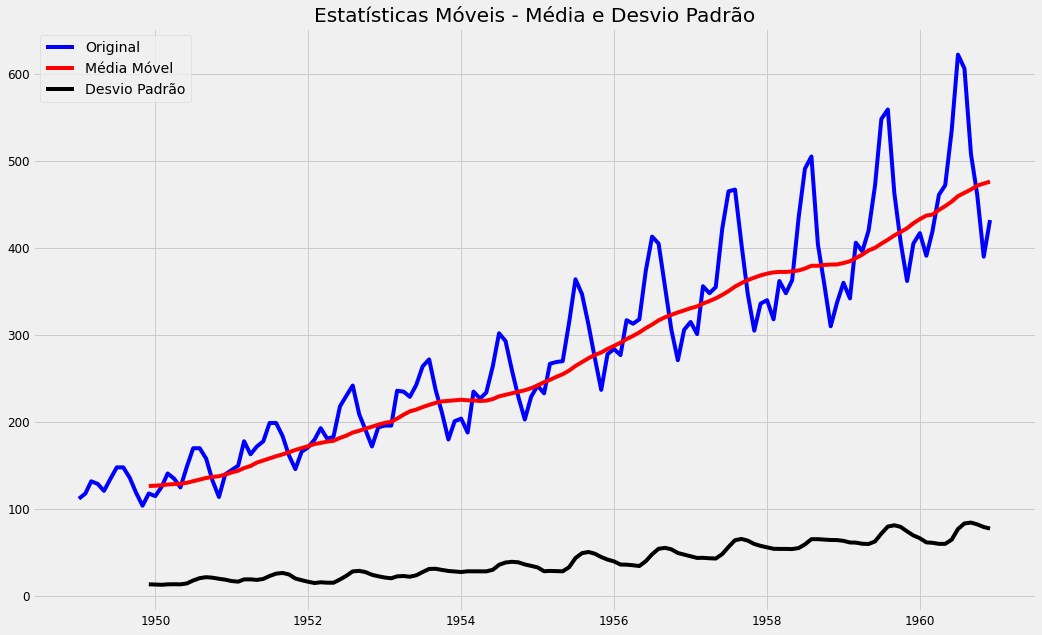


Resultado do Teste Dickey-Fuller:

Estatística do Teste              0.815369
Valor-p                           0.991880
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [0]:
# Executando nossa função
testa_estacionaridade(dados_serie)

# Fim